In [976]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

In [977]:
def find_intersections(h, v):
    """
    Given lists of horizontal and vertical lines in (rho, theta) form, returns list
    of (x, y) intersection points.
    """
    points = []
    for d1, a1 in h:
        for d2, a2 in v:
            A = np.array([[np.cos(a1), np.sin(a1)], [np.cos(a2), np.sin(a2)]])
            b = np.array([d1, d2])
            point = np.linalg.solve(A, b)
            points.append(point)
    return points

def draw_intersections(img, intersections):
    for i in range(len(intersections)):
        for row,col in intersections:
#             cv2.circle(img,(row, col), 5, (0,255,0), -1)
            
            font                   = cv2.FONT_HERSHEY_SIMPLEX
            position    = (row,col)
            fontScale              = 0.8
            fontColor              = (255,255,255)
            lineType               = 2

            cv2.putText(img,str(int(row)) + "|" + str(int(col)), 
            position, 
            font, 
            fontScale,
            fontColor,
            lineType)
    
    plt.imshow(img)

In [978]:
def hor_vert_lines(lines):
    """
    A line is given by rho and theta. Given a list of lines, returns a list of
    horizontal lines (theta=90 deg) and a list of vertical lines (theta=0 deg).
    """
    h = []
    v = []
    for i in range(len(lines)):
        distance, angle = lines[i][0]
        if angle < np.pi/6 or angle > np.pi-np.pi/6:
            v.append([distance, angle])
        elif angle > np.pi/3 and angle < np.pi-np.pi/3:
            h.append([distance, angle])
    return h, v

In [979]:
def find_edges(img):
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(gray,250,200)
    return edges

def draw_edges(edges):
    plt.imshow(edges,cmap = 'gray')

In [980]:
def find_lines(edges):
    lines = cv2.HoughLines(edges,1,np.pi/180,200)
    
    for i in range(len(lines)):
        distance, angle = lines[i][0]
        
        if distance < 0:
            lines[i][0][0] = abs(distance)
            lines[i][0][1] = lines[i][0][1] - np.pi
            
    return lines

def draw_lines(img, lines):
    for rho,theta in lines:
        a = np.cos(theta)
        b = np.sin(theta)
        x0 = a*rho
        y0 = b*rho
        x1 = int(x0 + 2000*(-b))
        y1 = int(y0 + 2000*(a))
        x2 = int(x0 - 2000*(-b))
        y2 = int(y0 - 2000*(a))

        cv2.line(img,(x1,y1),(x2,y2),(0,0,255),2)

    plt.imshow(img)

In [981]:
def remove_lines_outliers(lines, threshold):
    '''
        threshold - max distance between two lines
    '''
    lines.sort(key=lambda element: element[0])
    
    segmented_lines = []
    segmented_lines.append([lines[0]])
    
    index = 0
    for i in range(len(lines)-1):
        rho, _ = lines[i]
        rho1, _ = lines[i+1]
        
        if abs(rho-rho1) < threshold:
            segmented_lines[index].append(lines[i+1])
        else:
            index += 1
            segmented_lines.append([])
            segmented_lines[index].append(lines[i+1])
            
    filtered = []
    
    for segment in segmented_lines:
        filtered.append(segment[len(segment)//2])
    
    return filtered

In [982]:
def get_board_lines(hor_lines, vert_lines):
    return hor_lines[1:-1], vert_lines[1:-1]

In [983]:
def get_squares(corners): 
    squares = []
    
    col = 0
    row = 0
    
    squares_cnt = 0
    for i in range(len(corners)-9-1):
        
        if squares_cnt == 8:
            squares_cnt = 0
            continue
            
        top_left = corners[i]
        top_right = corners[i+1]
        bottom_left = corners[i+9]
        bottom_right = corners[i+9+1]
        
        square = [top_left, top_right, bottom_left, bottom_right]
        squares.append(square)
        
        squares_cnt += 1
        
    return squares

In [984]:
def get_square_image(img, square):
    crop_img = img[int(square[0][1]):int(square[2][1]), int(square[0][0]):int(square[1][0])]
    plt.imshow(crop_img)

True

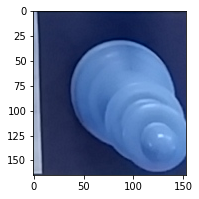

In [985]:
# img = cv2.imread(r'pictures_test\figure_sa_strane.jpg')
# img = cv2.imread(r'pictures_test\figure_od_gore.jpg')
# img = cv2.imread(r'pictures_test\slike\tabla.jpg')
img = cv2.imread(r'pictures_test\slike\sa_figurama3.jpg')

edges = find_edges(img)

plt.subplot(121)
draw_edges(edges)
cv2.imwrite('edges.jpg',edges)

lines = find_lines(edges)
hor_lines, vert_lines = hor_vert_lines(lines)

filtered_hor_lines = remove_lines_outliers(hor_lines, 25)
filtered_vert_lines = remove_lines_outliers(vert_lines, 25)

board_hor_lines, board_vert_lines = get_board_lines(filtered_hor_lines, filtered_vert_lines)

intersections = find_intersections(board_hor_lines, board_vert_lines)
squares = get_squares(intersections)
get_square_image(img, squares[62])
# draw_lines(img, board_hor_lines)
# draw_lines(img, board_vert_lines)
# draw_intersections(img, intersections)

cv2.imwrite('houghlines3.jpg',img)
